In [1]:
import sys
sys.path.append('..')

In [2]:
import pandas as pd

In [3]:
# given point

In [4]:
# read in tile_points.csv
points = pd.read_csv('../../data/tile_points.csv')

In [5]:
row = points.iloc[10000]

In [6]:
# find enclosing tile

In [3]:
from nbhd.data import Base

Initializing database connection...
Database connected!


In [4]:
db = Base()

In [5]:
from nbhd.geography import Neighbourhood

In [6]:
n = Neighbourhood(load=False)#row.x, row.y, 

In [11]:
# nearest roads ~ 'slimroads' is without motorways and secondary roads

In [7]:
nr_roads = n.db.nearest_neighbours('slimroads', n.geom.buffer(10))

In [8]:
nr_roads.head(1)

,UPRN,uprn_geometry,id,endNode,startNode,roadNumberTOID,roadNameTOID,fictitious,roadClassification,roadFunction,...,primaryRoute,trunkRoad,roadClassificationNumber,name1,name1_lang,name2,name2_lang,roadStructure,geometry,dist
0,38000001,0101000020346C0000000000003CB81441000000003CE9...,id5E137843-85D8-4E11-AFC6-4714A213B5D3,id1196BE64-808A-4DBE-B12F-606B6135E0F0,id136C88AB-84CB-4844-B3EA-250D06F589BF,None,osgb4000000013376071,False,Unclassified,Local Road,...,False,False,None,Abacus Road,None,None,None,None,"LINESTRING (339491.000 391787.000, 339491.000 ...",20.0


In [14]:
# nearest buildings

In [9]:
nr_buildings = n.db.nearest_neighbours('openmaplocal', n.geom.buffer(1))

In [10]:
nr_buildings.head(1)

,UPRN,uprn_geometry,id,featureCode,geometry,dist
0,38000001,0101000020346C0000000000003CB81441000000003CE9...,id339E7AF1-7293-4A9B-869D-E784D13C829F,15014,"POLYGON ((339479.680 391722.290, 339476.270 39...",0.0


In [25]:
# merge on UPRN

In [11]:
df = nr_buildings.merge(nr_roads, on=['UPRN', 'uprn_geometry'], how='inner', suffixes=('_building', '_street'))

In [12]:
df.head(1)

,UPRN,uprn_geometry,id_building,featureCode,geometry_building,dist_building,id_street,endNode,startNode,roadNumberTOID,...,primaryRoute,trunkRoad,roadClassificationNumber,name1,name1_lang,name2,name2_lang,roadStructure,geometry_street,dist_street
0,38000001,0101000020346C0000000000003CB81441000000003CE9...,id339E7AF1-7293-4A9B-869D-E784D13C829F,15014,"POLYGON ((339479.680 391722.290, 339476.270 39...",0.0,id5E137843-85D8-4E11-AFC6-4714A213B5D3,id1196BE64-808A-4DBE-B12F-606B6135E0F0,id136C88AB-84CB-4844-B3EA-250D06F589BF,None,...,False,False,None,Abacus Road,None,None,None,None,"LINESTRING (339491.000 391787.000, 339491.000 ...",20.0


In [64]:
# 1 eliminate non-building properties : distance to building must == 0

In [13]:
df1 = df.loc[df.dist_building==0]

In [67]:
# 2 eliminate non-residential buildings : area / uprn count must < 250

In [14]:
building_counts = dict(df1.id_building.value_counts())

In [15]:
df1['building_counts'] = df1.id_building.apply(lambda x: building_counts.get(x, 0))

<ipython-input-15-909eb256e9a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['building_counts'] = df1.id_building.apply(lambda x: building_counts.get(x, 0))


In [16]:
df1['footprint_area_per_uprn'] = df1.apply(lambda x: x.geometry_building.area / x.building_counts, axis=1)

<ipython-input-16-fa1193a36330>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['footprint_area_per_uprn'] = df1.apply(lambda x: x.geometry_building.area / x.building_counts, axis=1)


In [17]:
df1['residential_building'] = df1['footprint_area_per_uprn'] < 250

<ipython-input-17-dd708221cae7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['residential_building'] = df1['footprint_area_per_uprn'] < 250


In [18]:
df2 = df1.loc[df1.residential_building]

In [ ]:
# 3 establish whether roads are residential : length / uprn count must < 5??

In [19]:
street_counts = dict(df2.id_street.value_counts())

In [20]:
df2['street_counts'] = df2.id_street.apply(lambda x: street_counts.get(x, 0))

<ipython-input-20-be680ec1f918>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['street_counts'] = df2.id_street.apply(lambda x: street_counts.get(x, 0))


In [21]:
df2['street_length_per_uprn'] = df2.length / df2.street_counts

<ipython-input-21-0dd6277d304b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['street_length_per_uprn'] = df2.length / df2.street_counts


In [22]:
df2['residential_street'] = df2.apply(lambda x: any([(x.street_length_per_uprn < 20), (x.length < 20)]), axis = 1)

<ipython-input-22-66c4dc6c78e8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['residential_street'] = df2.apply(lambda x: any([(x.street_length_per_uprn < 20), (x.length < 20)]), axis = 1)


In [23]:
residential = dict(zip(df2.id_street, df2.residential_street))

In [24]:
df['residential_street'] = df.id_street.apply(lambda x: residential.get(x, False))

In [42]:
# 4 find connected networks of residential streets

In [43]:
import networkx as nx

In [ ]:
df

In [ ]:
# 5 find connected networks of residential and non-(B Road/ Minor Road) streets

In [27]:
import matplotlib.pyplot as plt

In [29]:
import geopandas as gpd

<AxesSubplot:>

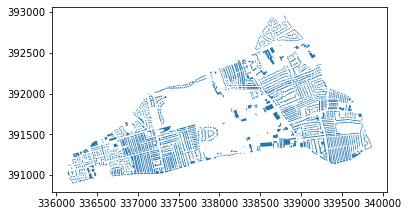

In [40]:
f, ax = plt.subplots(figsize=(12,12))

gdf0.plot('residential_street', ax=ax)
gpd.GeoSeries(df.geometry_building.unique()).plot()

In [30]:
gdf0 = gpd.GeoDataFrame(df[['residential_street', 'geometry_street']], geometry='geometry_street')

In [26]:
df2.loc[df.length<20].residential_street.unique()

array([ True])

<AxesSubplot:>

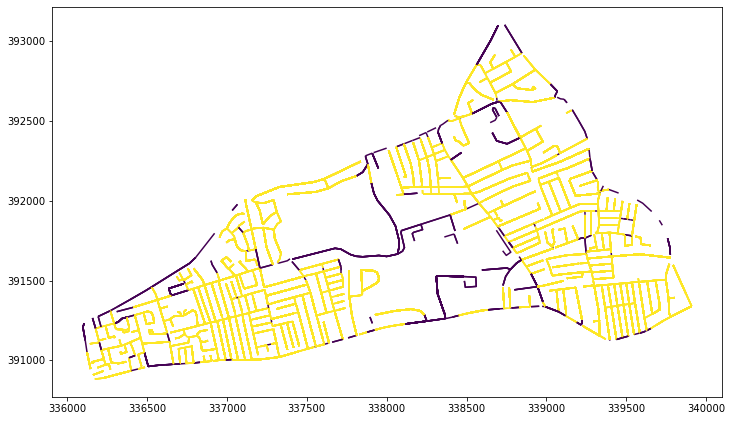

In [32]:
f, ax = plt.subplots(figsize=(12,12))

gdf0.plot('residential_street', ax=ax)

In [113]:
df2.street_length_per_uprn.describe()

count    14026.000000
mean         4.067161
std          7.339118
min          0.647619
25%          2.185185
50%          3.125000
75%          4.390244
max        491.000000
Name: street_length_per_uprn, dtype: float64

<AxesSubplot:ylabel='Frequency'>

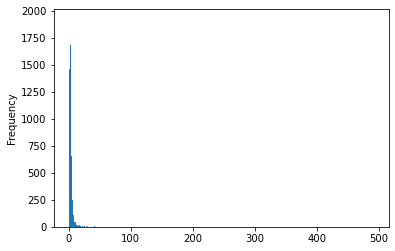

In [117]:
df2.street_length_per_uprn.plot.hist(bins=1000)

In [ ]:
# 4 find connected networks of residential roads

In [28]:
building_counts = dict(df.id_x.value_counts())

In [29]:
# road_counts = dict(df.id_y.value_counts()) # too early, wait until you know if they are residential

In [31]:
df['building_counts'] = df.id_x.apply(lambda x: building_counts.get(x,0))

In [42]:
df.iloc[0].geometry_x.area

419.63980000091635

In [43]:
df['footprint_per_uprn'] = df.apply(lambda x: x.geometry_x.area/x.building_counts, axis=1)

In [44]:
df['residential_building'] = df['footprint_per_uprn'] < 250

In [84]:
gdf = gpd.GeoDataFrame(df1[['residential_building','geometry_building']], geometry='geometry_building')

<AxesSubplot:>

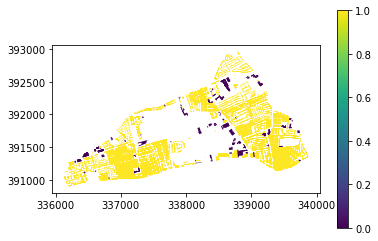

In [85]:
gdf.plot('residential_building', legend=True)

In [52]:
res_bdgs = df.loc[df.residential_building]

In [53]:
res_bdgs

,UPRN,uprn_geometry_x,id_x,featureCode,geometry_x,dist_x,uprn_geometry_y,id_y,endNode,startNode,...,name1,name1_lang,name2,name2_lang,roadStructure,geometry_y,dist_y,building_counts,footprint_per_uprn,residential_building
0,38000001,0101000020346C0000000000003CB81441000000003CE9...,id339E7AF1-7293-4A9B-869D-E784D13C829F,15014,"POLYGON ((339479.680 391722.290, 339476.270 39...",0.0,0101000020346C0000000000003CB81441000000003CE9...,id5E137843-85D8-4E11-AFC6-4714A213B5D3,id1196BE64-808A-4DBE-B12F-606B6135E0F0,id136C88AB-84CB-4844-B3EA-250D06F589BF,...,Abacus Road,None,None,None,None,"LINESTRING (339491.000 391787.000, 339491.000 ...",20.000000,7,59.948543,True
1,38000002,0101000020346C00000000000048B814410000000024E9...,id339E7AF1-7293-4A9B-869D-E784D13C829F,15014,"POLYGON ((339479.680 391722.290, 339476.270 39...",0.0,0101000020346C00000000000048B814410000000024E9...,id5E137843-85D8-4E11-AFC6-4714A213B5D3,id1196BE64-808A-4DBE-B12F-606B6135E0F0,id136C88AB-84CB-4844-B3EA-250D06F589BF,...,Abacus Road,None,None,None,None,"LINESTRING (339491.000 391787.000, 339491.000 ...",17.000000,7,59.948543,True
2,38000003,0101000020346C00000000000048B814410000000010E9...,id339E7AF1-7293-4A9B-869D-E784D13C829F,15014,"POLYGON ((339479.680 391722.290, 339476.270 39...",0.0,0101000020346C00000000000048B814410000000010E9...,id5E137843-85D8-4E11-AFC6-4714A213B5D3,id1196BE64-808A-4DBE-B12F-606B6135E0F0,id136C88AB-84CB-4844-B3EA-250D06F589BF,...,Abacus Road,None,None,None,None,"LINESTRING (339491.000 391787.000, 339491.000 ...",17.000000,7,59.948543,True
3,38000004,0101000020346C0000000000004CB8144100000000F8E8...,id339E7AF1-7293-4A9B-869D-E784D13C829F,15014,"POLYGON ((339479.680 391722.290, 339476.270 39...",0.0,0101000020346C0000000000004CB8144100000000F8E8...,id5E137843-85D8-4E11-AFC6-4714A213B5D3,id1196BE64-808A-4DBE-B12F-606B6135E0F0,id136C88AB-84CB-4844-B3EA-250D06F589BF,...,Abacus Road,None,None,None,None,"LINESTRING (339491.000 391787.000, 339491.000 ...",16.000000,7,59.948543,True
4,38000005,0101000020346C0000000000004CB8144100000000E0E8...,id339E7AF1-7293-4A9B-869D-E784D13C829F,15014,"POLYGON ((339479.680 391722.290, 339476.270 39...",0.0,0101000020346C0000000000004CB8144100000000E0E8...,id5E137843-85D8-4E11-AFC6-4714A213B5D3,id1196BE64-808A-4DBE-B12F-606B6135E0F0,id136C88AB-84CB-4844-B3EA-250D06F589BF,...,Abacus Road,None,None,None,None,"LINESTRING (339491.000 391787.000, 339491.000 ...",16.000000,7,59.948543,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15158,38000549,0101000020346C00000000000014BC144100000000B8E7...,id09CC6713-6ADD-450C-9CCE-D785D3B9E75D,15014,"POLYGON ((339697.480 391671.500, 339696.190 39...",0.0,0101000020346C00000000000014BC144100000000B8E7...,idBB1685EC-F135-4BAF-A3A4-2F814E01A57F,id845737B2-1891-45DD-A47D-9504C23F3C00,idBD9AE30B-2ACF-43FE-BF97-11AB6400215F,...,Acanthus Road,None,None,None,None,"LINESTRING (339777.400 391643.130, 339593.000 ...",11.891173,6,56.210250,True
15159,38000550,0101000020346C00000000000054BC14410000000038E7...,id2193B695-AF2D-44A8-9C8B-783744458EDE,15014,"POLYGON ((339696.190 391639.410, 339694.930 39...",0.0,0101000020346C00000000000054BC14410000000038E7...,idBB1685EC-F135-4BAF-A3A4-2F814E01A57F,id845737B2-1891-45DD-A47D-9504C23F3C00,idBD9AE30B-2ACF-43FE-BF97-11AB6400215F,...,Acanthus Road,None,None,None,None,"LINESTRING (339777.400 391643.130, 339593.000 ...",18.085575,8,49.679187,True
15160,38000551,0101000020346C00000000000028BC144100000000B8E7...,id09CC6713-6ADD-450C-9CCE-D785D3B9E75D,15014,"POLYGON ((339697.480 391671.500, 339696.190 39...",0.0,0101000020346C00000000000028BC144100000000B8E7...,idBB1685EC-F135-4BAF-A3A4-2F814E01A57F,id845737B2-1891-45DD-A47D-9504C23F3C00,idBD9AE30B-2ACF-43FE-BF97-11AB6400215F,...,Acanthus Road,None,None,None,None,"LINESTRING (339777.400 391643.130, 339593.000 ...",12.458792,6,56.210250,True
15161,38000552,0101000020346C00000000000044BC144100000000B4E7...,id09CC6713-6ADD-450C-9CCE-D785D3B9E75D,15014,"POLYGON (

In [57]:
res_bdgs.loc[res_bdgs.dist==0]

count    15009.000000
mean         0.739741
std          4.568566
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         99.735202
Name: dist_x, dtype: float64